# Classifying Unlocked Phone Reviews on Amazon
**University of San Diego, 2022**<br>
*Nava Roohi, Cole Bailey, Filipp Krasovsky*

## Table of Contents
<ol>
    <li>Introduction</li>
    <li>Phases</li>
    <li>Data Ingestion</li>
    <li>Noise Recognition</li>
    <li>Data Masking</li>
    <li>Normalization</li>

</ol>

### 1. Introduction
The high level goal of this project is to:
<ol>
  <li>Ingest data using an API or Web Scraping tool</li>
  <li>Clean, tokenize, and otherwise normalize text data</li>
  <li>Linguistically process elements such as POS, NER, etc.</li>
  <li>Address class imbalances</li>
  <li>Create Feature vectors</li>
  <li>Train a model that can categorize reviews by rating</li>
  <li>Test the model against unseen data</li>
</ol>

<b>Dataset Background</b>
<p>The data used for this exercise is the Amazon Reviews dataset for unlocked mobile phones, which can be downloaded <a href="https://www.kaggle.com/datasets/PromptCloudHQ/amazon-reviews-unlocked-mobile-phones">here.</a></p>

### 2. Phases
#### Phase 1: Data Ingestion and Cleaning

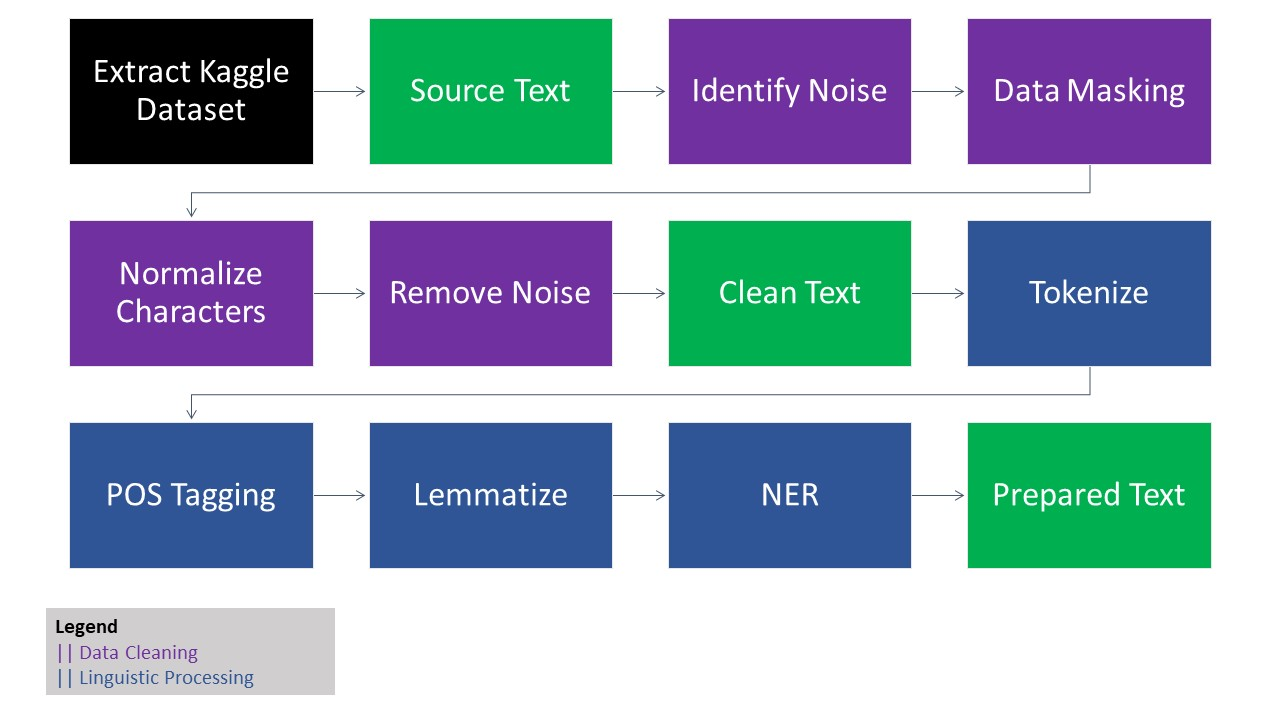

In [13]:
from IPython.display import Image
Image(filename='data_ingestion_pipeline.jpg') 

#### Phase 2: Feature Engineering and Training

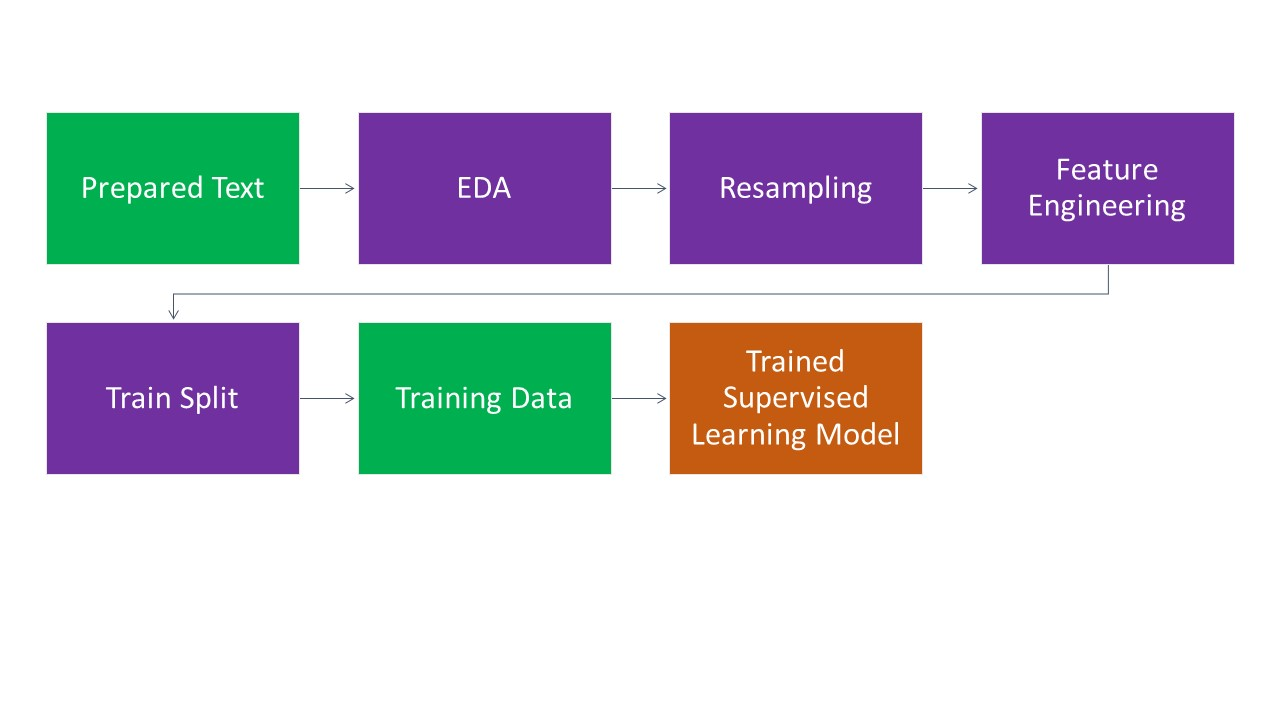

In [15]:
Image(filename='phase2.jpg') 

### 3. Data Ingestion
We begin by using the kaggle api to download our amazon reviews dataset to our current directory.
We can accomplish this by leaving the download path argument blank when we send our API request.

In [2]:
import kaggle
import pandas as pd
import matplotlib.pyplot as plt 
import pyarrow
import fastparquet
import numpy as np
import os
from collections import Counter, defaultdict
import warnings
import seaborn as sns
warnings.filterwarnings("ignore")
from wordcloud import WordCloud 
kaggle.api.authenticate()
import nltk
from string import punctuation
import textacy.preprocessing as tprep
from nltk.corpus import stopwords
from wordcloud import WordCloud, STOPWORDS
import spacy
nlp = spacy.load("en_core_web_sm")
from sklearn.metrics import accuracy_score 
from sklearn.metrics import roc_auc_score
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import LinearSVC


In [3]:
kaggle.api.dataset_download_files(
    'PromptCloudHQ/amazon-reviews-unlocked-mobile-phones', 
    unzip=True
)

In [4]:
df = pd.read_csv('Amazon_Unlocked_Mobile.csv')
df = df.rename(columns={"Reviews": "text"})
df.head()

,Product Name,Brand Name,Price,Rating,text,Review Votes
0,"""CLEAR CLEAN ESN"" Sprint EPIC 4G Galaxy SPH-D7...",Samsung,199.99,5,I feel so LUCKY to have found this used (phone...,1.0
1,"""CLEAR CLEAN ESN"" Sprint EPIC 4G Galaxy SPH-D7...",Samsung,199.99,4,"nice phone, nice up grade from my pantach revu...",0.0
2,"""CLEAR CLEAN ESN"" Sprint EPIC 4G Galaxy SPH-D7...",Samsung,199.99,5,Very pleased,0.0
3,"""CLEAR CLEAN ESN"" Sprint EPIC 4G Galaxy SPH-D7...",Samsung,199.99,4,It works good but it goes slow sometimes but i...,0.0
4,"""CLEAR CLEAN ESN"" Sprint EPIC 4G Galaxy SPH-D7...",Samsung,199.99,4,Great phone to replace my lost phone. The only...,0.0


Next, we can do a cursory overview of several data points:
<ul>
    <li>What our distribution of ratings is</li>
    <li>What our distribution of prices is</li>
    <li>What our distribution of review length is</li>
</ul>

#### 3a. Rating Distribution and Price Distribution

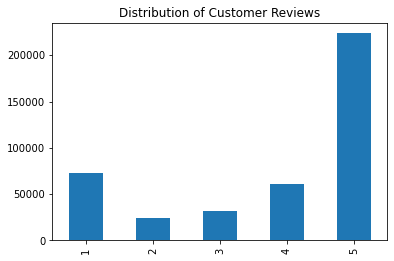

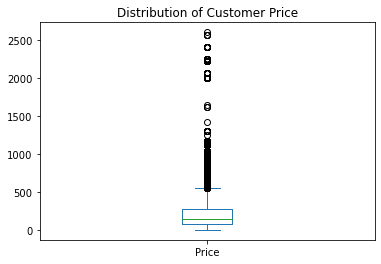

In [5]:
df['Rating'].value_counts().sort_index().plot(kind='bar',title="Distribution of Customer Reviews")
plt.show()
df['Price'].plot(kind='box',title="Distribution of Customer Price")
plt.show()

#### 3b. Review Length Distribution
Our findings show that while the majority of reviews are at around 100 characters, some reviews are fairly extensive. We may consider setting an upper bound on the number of characters we're willing to accept to avoid higher dimensionality.

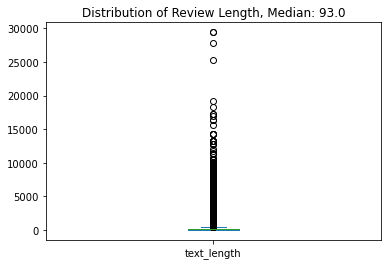

In [6]:
#create the length feature
df['text'] = df['text'].astype(str)
df['text_length'] = df['text'].map(len)
#get the median character length
median_len = str(np.median(df['text_length']))
sdev = np.std(df['text_length'])
df['text_length'].plot(kind='box',title=f'Distribution of Review Length, Median: {median_len}')
plt.show()

In [7]:
#how many outliers do we have?
mean_len= np.mean(df['text_length'])
within_two_sd = df[abs(df['text_length'] - mean_len) <= 2*sdev]
print(len(within_two_sd)/len(df))

0.9712666731103808


about 3% of our dataset has a text length two standard deviations or more from the mean. Let's examine what our boxplot looks like if we were to remove these. We may also want to consider the fact that we have not cleaned our data yet, so much of this EDA is to be taken with a grain of salt.

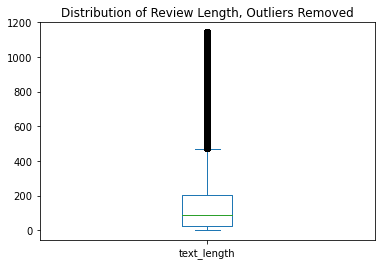

In [8]:
within_two_sd['text_length'].plot(kind='box',title=f'Distribution of Review Length, Outliers Removed')
plt.show()
del within_two_sd #clear kernel space

#### 3c. Do Price and Review Length share a connection?

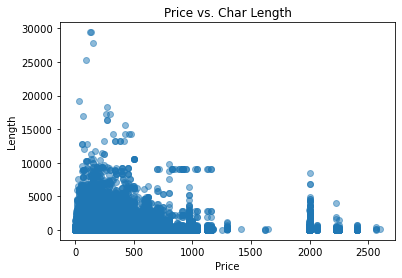

In [9]:
plt.scatter(df['Price'], df['text_length'], alpha=0.5)
plt.title("Price vs. Char Length")
plt.xlabel("Price")
plt.ylabel("Length")
plt.show()

#### 4. Noise Recognition
#### 4a. Text Impurity
To begin, we can use a function that identifies suspicious characters and returns an impurity score from 0 to 1 for each review.

In [10]:
import re
RE_SUSPICIOUS = re.compile(r'[&#<>{}\[\]\\]')

#create a function that keeps track of how impure our datasets are to see how much cleaning is needed and 
#if our cleaning had any meaningful effect.

def impurity(text, min_len=10):
    """returns the share of suspicious characters in a text"""
    if text == None or len(text) < min_len:
        return 0
    else:
        return len(RE_SUSPICIOUS.findall(text))/len(text)
    
def impurity_list(text,min_len=10):
    """ returns the list of suspicious characters in a text.
        iterate over the list of tokens and return every word with suspicious characters.
    """
    if text == None or len(text) < min_len:
        return []
    else:
        impure_words = []
        tokens = text.split()
        for t in tokens:
            if len(RE_SUSPICIOUS.findall(t))>0:
                impure_words.append(t)
        return impure_words

In [11]:
#map the function to a new column
df['impurity'] = df['text'].map(impurity)
df['impure_words'] = df['text'].map(impurity_list)
df.head(3)

,Product Name,Brand Name,Price,Rating,text,Review Votes,text_length,impurity,impure_words
0,"""CLEAR CLEAN ESN"" Sprint EPIC 4G Galaxy SPH-D7...",Samsung,199.99,5,I feel so LUCKY to have found this used (phone...,1.0,374,0.008021,"[&, &, &]"
1,"""CLEAR CLEAN ESN"" Sprint EPIC 4G Galaxy SPH-D7...",Samsung,199.99,4,"nice phone, nice up grade from my pantach revu...",0.0,214,0.000000,[]
2,"""CLEAR CLEAN ESN"" Sprint EPIC 4G Galaxy SPH-D7...",Samsung,199.99,5,Very pleased,0.0,12,0.000000,[]


we can now take steps to determine our worst-case scenario for text purity by getting the top 5 most impure values and generating a histogram.
**Findings show that the majority of reviews fall under 5% impurity, with a handful of outliers in a negligible quantity.**

        impurity                                       impure_words
113456  0.428571                           [Good####, Service#####]
114317  0.428571                           [Good####, Service#####]
261274  0.363918  [helps.>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>...
291904  0.281250                          [MORE>>>>>>>>>SOON!!!!!!]
291934  0.281250                          [MORE>>>>>>>>>SOON!!!!!!]
348810  0.187500                                       [<3, <3, <3]
142761  0.161290                           [$%@%#'#%'#'#:#:?!!!!!!]
141961  0.161290                           [$%@%#'#%'#'#:#:?!!!!!!]
67467   0.115385                                              [>>>]
120616  0.100000                                       [#it's_okay]


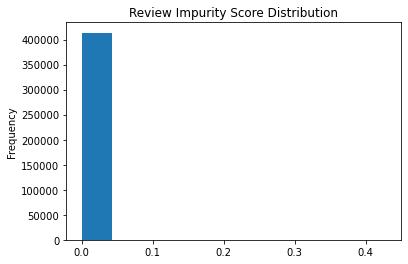

In [12]:
print(df[['impurity','impure_words']].sort_values(by='impurity',ascending=False).head(10))
df['impurity'].plot(kind='hist',bins=10,title='Review Impurity Score Distribution')
plt.show()

### 5. Data Masking

In this section, we're interested in identifying emails, URLs, and possibly phone numbers. We can use regex to:
<ul>
    <li>validate this information exists in the dataset in non-trivial amounts.</li>
    <li>replace or otherwise remove it.</li>
</ul>

In [13]:
#first, we create regex that can detect emails and urls.
url = re.compile("(https?:\/\/(?:www\.|(?!www))[a-zA-Z0-9][a-zA-Z0-9-]+[a-zA-Z0-9]\.[^\s]{2,}|www\.[a-zA-Z0-9][a-zA-Z0-9-]+[a-zA-Z0-9]\.[^\s]{2,}|https?:\/\/(?:www\.|(?!www))[a-zA-Z0-9]+\.[^\s]{2,}|www\.[a-zA-Z0-9]+\.[^\s]{2,})", re.IGNORECASE)
email = re.compile('\S+@\S+\.\S+')
phone_numbers=re.compile(r'(\d{3}[-\.\s]??\d{3}[-\.\s]??\d{4}|\(\d{3}\)\s*\d{3}[-\.\s]??\d{4}|\d{3}[-\.\s]??\d{4})')

mask_pipeline = {'urls':url,'emails':email,'phones':phone_numbers}

In [14]:
#iterate over our regex pipeline and store the output in df
for reg in mask_pipeline.keys():
    df[reg] = df['text'].map(mask_pipeline[reg].findall)

In [15]:
df.sort_values(by='urls',ascending=False).head(3)

,Product Name,Brand Name,Price,Rating,text,Review Votes,text_length,impurity,impure_words,urls,emails,phones
394686,SONY XPERIA Z3 COMPACT D5803 16GB (FACTORY UNL...,Sony,799.00,5,I just spent 2 hours with Gloria Estefan in th...,NaN,118,0.0,[],[www.youtube.com/watch?v=g8v6cZ21vlc],[],[]
402109,Sudroid Z18 Android 4.2 Mini Water and Dust-pr...,Fosler Corporation,72.99,4,"Discovery Z18 - says ""Vogue Phone"" on backEsse...",29.0,1597,0.0,[],"[www.youtube.com/watch?v=XWLBKSAwoiM(Root, htt...",[],[]
402068,Sudroid Z18 2.45 Inches Unlocked Mini Phone wi...,NaN,69.99,4,"Discovery Z18 - says ""Vogue Phone"" on backEsse...",29.0,1597,0.0,[],"[www.youtube.com/watch?v=XWLBKSAwoiM(Root, htt...",[],[]


After we find each kind of information, we want to get a sense of how prevalent it is in the data as well as validate that we actually identified URLs, emails, etc. with our regex mapping. One way to do this is by creating a counter and seeing if the output matches the structure of an email, phone number, or URL.

In [16]:
#get a broad sense of the presence of each type of information to be masked.
'a function that accepts a data series of tokens and combiens them into one list.'
def combine_tokens(tokens):
    out = []
    for token_list in tokens:
        out = out + token_list
    return out

def get_frequency(tokensObj,count_name = 'count'):
    #convert into a list.
    tokens_count = Counter(combine_tokens(tokensObj))
    count_df = pd.DataFrame.from_dict(tokens_count, orient='index').reset_index()
    return(count_df.rename(columns={'index':'token',0:count_name}))

In [17]:
for reg in mask_pipeline.keys():
    this_list = get_frequency(df[reg])
    n = this_list['count'].count()
    s = this_list['count'].sum()
    print(f'there are {n} unique values in {reg} with a total of {s} occurences')
    print(this_list.head())
    print('--------------\n')

there are 302 unique values in urls with a total of 675 occurences
                                               token  count
0  https://www.amazon.com/gp/aw/d/B01GYUDMFY/ref=...      2
1  http://www.amazon.com/gp/product/B00EY7SS72/re...      3
2  http://www.amazon.com/gp/product/B00PEJQU9M?re...      2
3  http://www.amazon.com/gp/product/B00ZOER95Q?ps...      1
4                       https://youtu.be/JU-dDjKi4Ig      1
--------------

there are 105 unique values in emails with a total of 227 occurences
                               token  count
0                      Quad-core@1.3      3
1  PLEASE!!!!!carolderenzo@yahoo.com      2
2                  hunalfi@gmail.com      2
3        mohamedjawahiri@hotmail.com      1
4         CarlosGolosina@hotmail.com      1
--------------

there are 249 unique values in phones with a total of 550 occurences
          token  count
0  843-709-3118      1
1    1717308766      1
2  855-368-0829      1
3    2407749011      2
4    2153843082      1
-

**Conclusion: The majority of our data does not contain information that needs to be masked, but we will still replace these instances with blank spaces. initial obvservations suggest that our regex expressions correctly identified the information we were looking for.**

In [18]:
#iterate over our regex pipeline and change our text to not contain masked data.
for k,v in mask_pipeline.items():
    df['text'] = df['text'].apply(lambda x: v.sub("",str(x)))

In [19]:
#iterate over our regex pipeline and recalculate the output in df
for reg in mask_pipeline.keys():
    df[reg] = df['text'].map(mask_pipeline[reg].findall)

#sanity check one more time after re-running
for reg in mask_pipeline.keys():
    this_list = get_frequency(df[reg])
    print(this_list)
    print('--------------\n')

Empty DataFrame
Columns: [token]
Index: []
--------------

Empty DataFrame
Columns: [token]
Index: []
--------------

Empty DataFrame
Columns: [token]
Index: []
--------------



### 6. Data Normalization

In [20]:
#lower case
df['new_reviews'] = df['text'].apply(lambda x: " ".join(x.lower() for x in x.split()))
#remove punctuation
df['new_reviews'] = df['new_reviews'].str.replace('[^\w\s]','')
# removing stopwords
stop = stopwords.words('english')
df['new_reviews'] = df['new_reviews'].apply(lambda x: " ".join(x for x in x.split() if x not in stop))

df['new_reviews']


0         feel lucky found used phone us used hard phone...
1         nice phone nice grade pantach revue clean set ...
2                                                   pleased
3            works good goes slow sometimes good phone love
4         great phone replace lost phone thing volume bu...
                                ...                        
413835                       another great deal great price
413836                                                   ok
413837           passes every drop test onto porcelain tile
413838     returned meet needs seemed good selection others
413839    downside apparently verizon longer uses vcast ...
Name: new_reviews, Length: 413840, dtype: object

### 7. Tokenization

we can tokenize our data using the spacy library. This initialization also allows us to create a pipeline for POS tagging, lemmatization, and NER as well as tokenization.

In [21]:
import spacy
import textacy
nlp = spacy.load('en_core_web_sm')
nlp.pipeline

[('tok2vec', <spacy.pipeline.tok2vec.Tok2Vec at 0x7fd774e309a0>),
 ('tagger', <spacy.pipeline.tagger.Tagger at 0x7fd774a9cb20>),
 ('parser', <spacy.pipeline.dep_parser.DependencyParser at 0x7fd774e356d0>),
 ('attribute_ruler',
  <spacy.pipeline.attributeruler.AttributeRuler at 0x7fd7e59add40>),
 ('lemmatizer',
  <spacy.lang.en.lemmatizer.EnglishLemmatizer at 0x7fd76037eac0>),
 ('ner', <spacy.pipeline.ner.EntityRecognizer at 0x7fd774e35890>)]

In [22]:
#apply this pipeline to our df to generate tokens:
def extract_nlp(doc):
    return {
        'lemmas' : extract_lemmas(doc,
        exclude_pos = ['PART', 'PUNCT',
        'DET', 'PRON', 'SYM', 'SPACE'],
        filter_stops = False),
        'adjs_verbs' : extract_lemmas(doc, include_pos = ['ADJ', 'VERB']),
        'nouns' : extract_lemmas(doc, include_pos = ['NOUN', 'PROPN']),
        'noun_phrases' : extract_noun_phrases(doc, ['NOUN']),
        'adj_noun_phrases': extract_noun_phrases(doc, ['ADJ']),
        'entities' : extract_entities(doc, ['PERSON', 'ORG', 'GPE', 'LOC'])
    }

def extract_lemmas(doc, **kwargs):
    return [t.lemma_ for t in textacy.extract.words(doc, **kwargs)]

def extract_noun_phrases(doc, preceding_pos=['NOUN'], sep='_'):
    patterns = []
    for pos in preceding_pos:
        patterns.append(f"POS:{pos} POS:NOUN:+")
    spans = textacy.extract.matches.token_matches(doc, patterns=patterns)
    return [sep.join([t.lemma_ for t in s]) for s in spans]

def extract_entities(doc, include_types=None, sep='_'):
    ents = textacy.extract.entities(doc,
    include_types=include_types,
    exclude_types=None,
    drop_determiners=True,
    min_freq=1)
    return [sep.join([t.lemma_ for t in e])+'/'+e.label_ for e in ents]

In [23]:
#initialize empty columns for each linguistic component we will populate to avoid errors.
docs = nlp.pipe([''])
for j,doc in enumerate(docs):
    for col,values in extract_nlp(doc).items():
        df[col] = None

In [24]:
#create a df column for each of our linguistic pipeline steps!

import time
import tqdm.notebook as tq
start = time.localtime()
batch_size = 50

for i in tq.tqdm(range(0, len(df), batch_size),position=0,leave=True):
    docs = nlp.pipe(df['new_reviews'][i:i+batch_size])
    for j, doc in enumerate(docs):
        for col, values in extract_nlp(doc).items():
            df[col].iloc[i+j] = values
            
end = time.localtime()
print(start,end)

In [25]:
#remove irrelevant columns to produce a final version for working with models.
df = df[[
    'Rating','new_reviews','lemmas','adjs_verbs','nouns','noun_phrases','adj_noun_phrases','entities'
]]
df['tokens'] = df['new_reviews'].map(str.split)
df.head()

,Rating,new_reviews,lemmas,adjs_verbs,nouns,noun_phrases,adj_noun_phrases,entities,tokens
0,5,feel lucky found used phone us used hard phone...,None,None,None,None,None,None,"[feel, lucky, found, used, phone, us, used, ha..."
1,4,nice phone nice grade pantach revue clean set ...,None,None,None,None,None,None,"[nice, phone, nice, grade, pantach, revue, cle..."
2,5,pleased,None,None,None,None,None,None,[pleased]
3,4,works good goes slow sometimes good phone love,None,None,None,None,None,None,"[works, good, goes, slow, sometimes, good, pho..."
4,4,great phone replace lost phone thing volume bu...,None,None,None,None,None,None,"[great, phone, replace, lost, phone, thing, vo..."


Finally, with all the needed components for our prepared text, we save to parquet as a checkpoint.

In [26]:
df.to_parquet('prepared_text.parquet.gzip',
              compression='gzip',
              index=False)  